# Fuel Performance Data Set

In [7]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
settings = {
    "verbosity": 0,
    "random_state": None,
    "test_size": 0.3,
    "num_configs_saved": 5,
}
global_settings = mai.settings.init(settings_changes=settings)
preprocessor = mai.load_fp()

In [4]:
preprocessor.inputs.head()

,fuel_dens,porosity,clad_thick,pellet_OD,pellet_h,gap_thick,inlet_T,enrich,rough_fuel,rough_clad,ax_pow,clad_T,pressure
0,10466,0.040527,0.000571,0.004104,0.013077,0.000019,292.36,0.044852,0.000002,3.890000e-07,0.99967,602.72,15504000
1,10488,0.041780,0.000570,0.004096,0.014227,0.000019,291.33,0.044942,0.000002,4.170000e-07,0.98741,602.81,15591000
2,10434,0.058323,0.000568,0.004094,0.013923,0.000019,293.35,0.044889,0.000002,3.670000e-07,0.99225,620.33,15510000
3,10449,0.038379,0.000572,0.004093,0.013976,0.000019,293.29,0.044937,0.000002,3.250000e-07,1.02650,610.91,15382000
4,10429,0.038438,0.000568,0.004096,0.013787,0.000019,291.81,0.044849,0.000002,4.360000e-07,0.99289,597.05,15583000


In [5]:
preprocessor.outputs.head()

,fis_gas_produced,max_fuel_centerline_temp,max_fuel_surface_temp,radial_clad_dia
0,0.000029,1569.699310,699.613033,0.000019
1,0.000032,1559.465162,699.976191,0.000019
2,0.000031,1632.394103,712.771506,0.000020
3,0.000032,1613.399315,710.114032,0.000020
4,0.000031,1542.540705,694.956854,0.000018


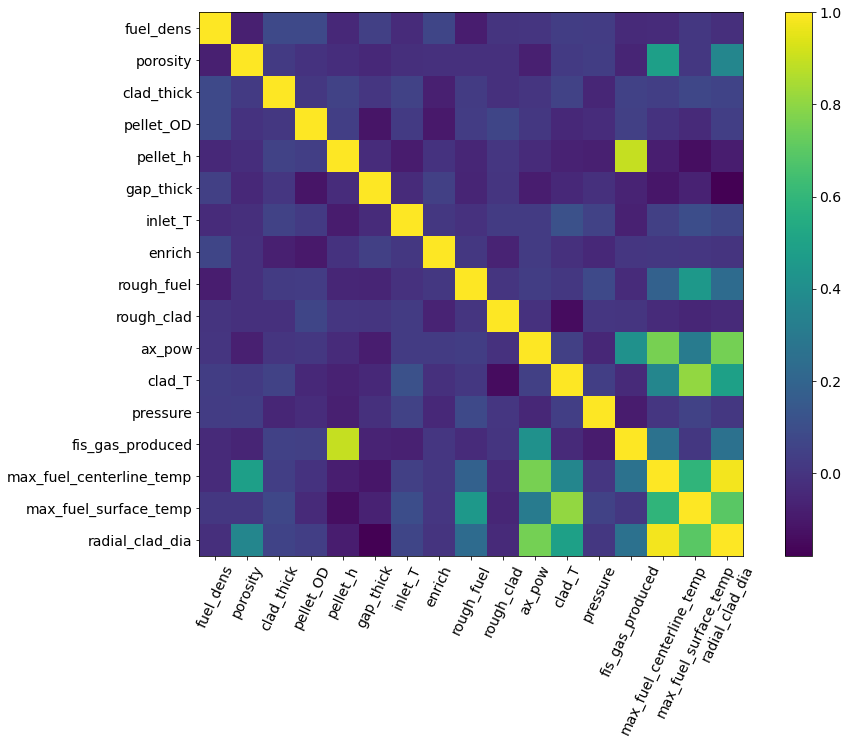

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax)

In [9]:
data = preprocessor.min_max_scale()

In [20]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": "mean_absolute_error",
        "batch_size": 8,
        "epochs": 50,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear",  # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1],  # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

random_search_dist = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 2 - 20
        "max_features": [None, 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=3, high=20), # 3 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=5, high=30), # 5 - 30
        "p": randint(low=2, high=10), # 2 - 10
    },
}
bayesian_search_limits = {
    "nn": {
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 6],
        "start_num_nodes": [50, 200],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_distributions=random_search_dist, 
    models=["linear"] + list(random_search_dist.keys()), 
    n_iter=100, 
    cv=ShuffleSplit(n_splits=10, test_size=0.15, random_state=settings["random_state"]),
)
bayesian_search_configs = tuning.bayesian_search(
    search_spaces=bayesian_search_limits,
    models=bayesian_search_limits.keys(),
    n_iter=50,
    cv=[(slice(None), slice(None))],
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 10.701605844497681 minutes to process.


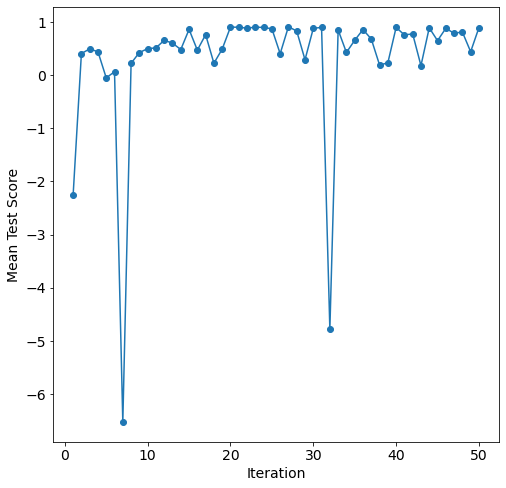

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(models="nn")

In [25]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings
)

In [26]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
25,nn,"{'batch_size': 8, 'learning_rate': 0.000968569...",0.956143,0.026679,0.001208,0.034756,0.803581,0.074628,0.007465,0.086403
1,lasso,{'alpha': 0.00023689074414087806},0.979010,0.014707,0.000543,0.023301,0.757323,0.084445,0.009290,0.096383
0,linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.979590,0.014234,0.000527,0.022960,0.757183,0.084582,0.009305,0.096463
2,lasso,{'alpha': 0.00027550246940903536},0.978827,0.014830,0.000548,0.023408,0.757152,0.084442,0.009295,0.096408
3,lasso,{'alpha': 0.0003365187366292297},0.978502,0.015035,0.000557,0.023597,0.756855,0.084459,0.009303,0.096453
4,lasso,{'alpha': 0.0004760444652472955},0.977593,0.015587,0.000581,0.024114,0.755945,0.084558,0.009331,0.096599
5,lasso,{'alpha': 0.0005022943283391336},0.977404,0.015709,0.000587,0.024221,0.755766,0.084575,0.009337,0.096629
23,nn,"{'batch_size': 8, 'learning_rate': 0.000936919...",0.970827,0.020827,0.000788,0.028073,0.755364,0.084673,0.009323,0.096553
24,nn,"{'batch_size': 8, 'learning_rate': 0.000919176...",0.976730,0.017690,0.000621,0.024918,0.730366,0.089932,0.010303,0.101501
22,nn,"{'batch_size': 8, 'learning_rate': 0.000952735...",0.970161,0.021633,0.000800,0.028282,0.725447,0.089881,0.010461,0.102278


In [27]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs   normalize  positive
0      linear    True           True   None  deprecated     False 

  Model Types     alpha
0       lasso  0.000237 

  Model Types  max_depth max_features  min_samples_leaf  min_samples_split
0       dtree         39         None                 5                  2 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn          6            5  2  distance 

  Model Types      criterion max_features  min_samples_leaf  \
0     rforest  squared_error         None                 3   

   min_samples_split  n_estimators  
0                 12           133   

  Model Types  batch_size  learning_rate  num_layers  start_num_nodes
0          nn           8       0.000969           2              200 



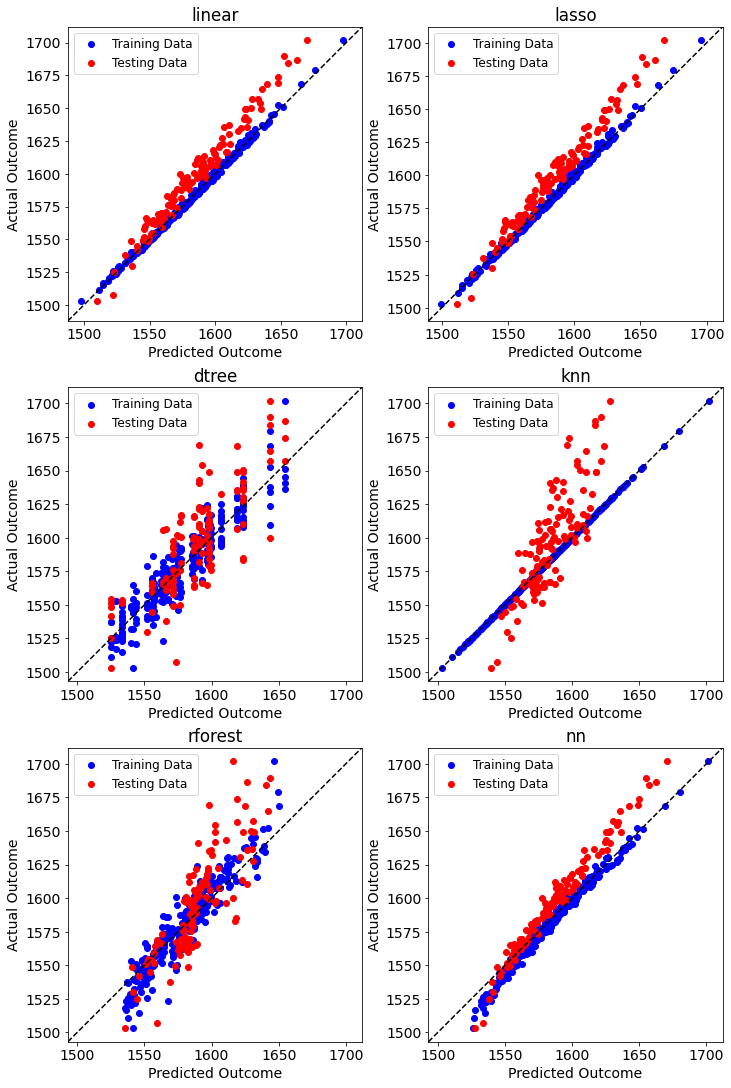

In [40]:
models = np.array([["linear", "lasso"], ["dtree", "knn"], ["rforest", "nn"]])

output = ["max_fuel_centerline_temp"]

fig = plt.figure(constrained_layout=fig, figsize=(10,15))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(
                model_type=models[i, j], 
                yscaler=preprocessor.yscaler, 
                y=output,
            )
            ax.set_title(models[i, j])

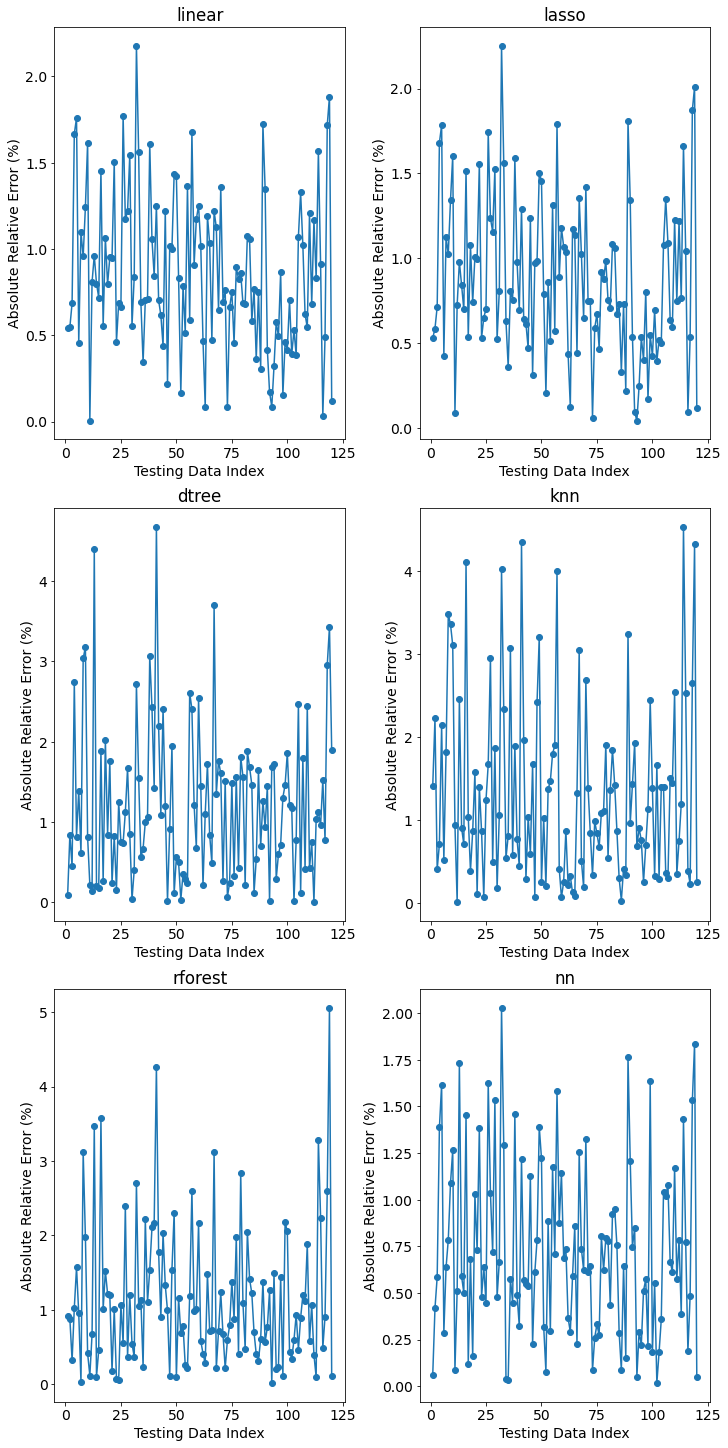

In [36]:
fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.validation_plot(
                model_type=models[i, j], 
                yscaler=preprocessor.yscaler, 
                y=output,
            )
            ax.set_title(models[i, j])

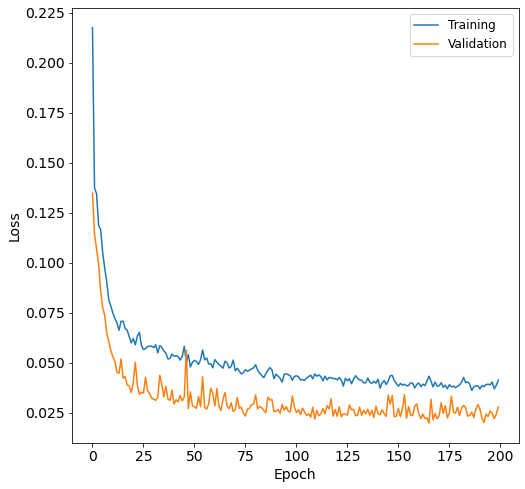

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

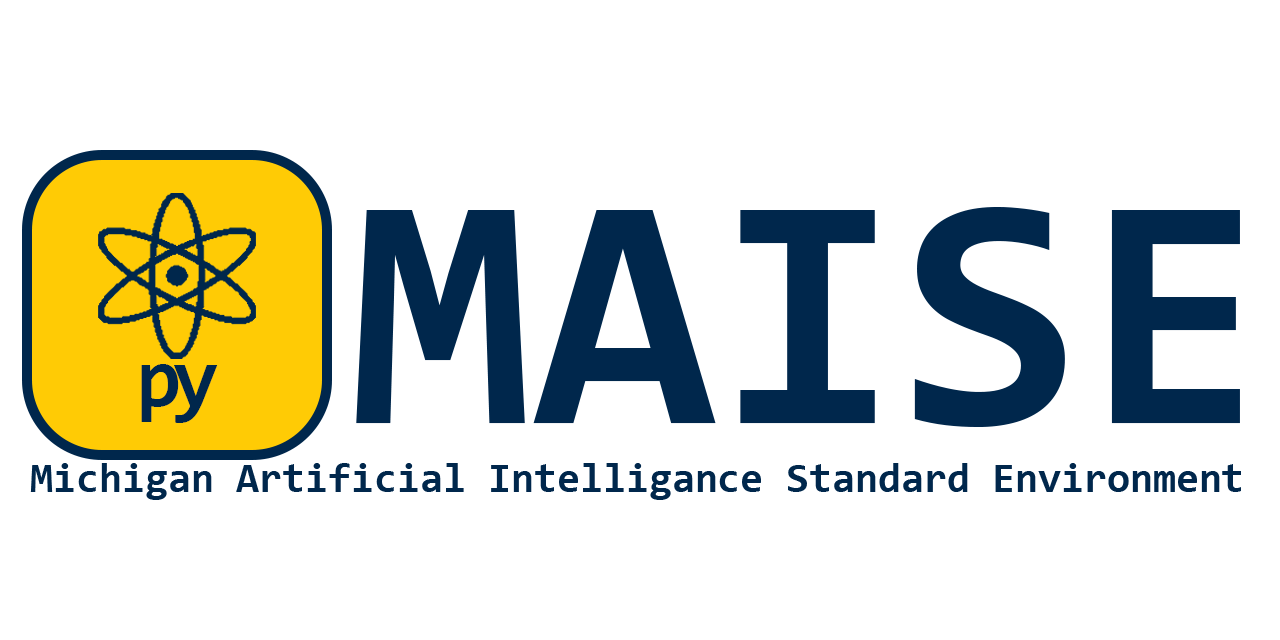